### The target column is Volumes Sold in liters or gallons. Try to create models that will predict this value.

In [1]:
# import the librari
import pandas as pd
import numpy as np

import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer

### 1. Load and analyze the data set, and try to extract insights from the data.
### 2.	Prepare the data to machine learning algorithm ready format.

In [2]:
df = pd.read_csv("lowa_liquor_sales.csv", low_memory=False)

In [3]:
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


### optimize the data
- optimize: use country code insted of the country name
- delete volume sold into Gallons
- item number instead of the intem description - item number = item description
- use store number without store name
- use zip code instead of city

- need to drop: country name, gallons, item number, store name, city

In [4]:
# select the columns that should be dropted
columns_to_drop = ['Store Name', 'Address', 'City', 'Store Location', 'County Number', 'County', 'Category Name', 'Vendor Name', 'Item Description',  'Volume Sold (Gallons)']

# drop the columns
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# replace the dollar signs '$' from the specified columns in the main DataFrame 'df'
columns_to_replace = ['State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']
df[columns_to_replace] = df[columns_to_replace].replace('[\$,]', '', regex=True).astype(float)

In [6]:
# convert Zip Code to int
df['Zip Code'] = pd.to_numeric(df['Zip Code'], errors='coerce').astype('Int64')

# convert State Bottle Cost to float
df['State Bottle Cost'] = pd.to_numeric(df['State Bottle Cost'], errors='coerce')

# convert State Bottle Retail to float
df['State Bottle Retail'] = pd.to_numeric(df['State Bottle Retail'], errors='coerce')

# convert Sale (Dollars) to float
df['Sale (Dollars)'] = pd.to_numeric(df['Sale (Dollars)'], errors='coerce')

# convert Vendor Number to float
df['Vendor Number'] = pd.to_numeric(df['Vendor Number'], errors='coerce')

# ensure the columns have been converted to the correct data types
print(df.dtypes)


Invoice/Item Number      object
Date                     object
Store Number              int64
Zip Code                  Int64
Category                float64
Vendor Number           float64
Item Number               int64
Pack                      int64
Bottle Volume (ml)        int64
State Bottle Cost       float64
State Bottle Retail     float64
Bottles Sold              int64
Sale (Dollars)          float64
Volume Sold (Liters)    float64
dtype: object


In [7]:
df.head(10)

,Invoice/Item Number,Date,Store Number,Zip Code,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
0,S29198800001,11/20/2015,2191,52632,NaN,255.0,297,6,750,18.09,27.14,6,162.84,4.50
1,S29195400002,11/21/2015,2205,51632,NaN,255.0,297,6,750,18.09,27.14,12,325.68,9.00
2,S29050300001,11/16/2015,3549,52627,NaN,130.0,249,20,150,6.40,9.60,2,19.20,0.30
3,S28867700001,11/04/2015,2513,52240,NaN,65.0,237,3,1750,35.55,53.34,3,160.02,5.25
4,S29050800001,11/17/2015,3942,52342,NaN,130.0,249,20,150,6.40,9.60,2,19.20,0.30
5,S28869200001,11/11/2015,3650,51025,NaN,65.0,237,3,1750,35.55,53.34,1,53.34,1.75
6,S28865700001,11/09/2015,2538,50702,1701100.0,962.0,238,6,1500,11.62,17.43,6,104.58,9.00
7,S28869500001,11/10/2015,3942,52342,NaN,65.0,237,3,1750,35.55,53.34,2,106.68,3.50
8,S29339300091,11/30/2015,2662,52761,1701100.0,65.0,173,12,750,19.58,29.37,4,117.48,3.00
9,S29050900001,11/16/2015,4307,<NA>,NaN,130.0,249,20,150,6.40,9.60,2,19.20,0.30


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12591077 entries, 0 to 12591076
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Invoice/Item Number   object 
 1   Date                  object 
 2   Store Number          int64  
 3   Zip Code              Int64  
 4   Category              float64
 5   Vendor Number         float64
 6   Item Number           int64  
 7   Pack                  int64  
 8   Bottle Volume (ml)    int64  
 9   State Bottle Cost     float64
 10  State Bottle Retail   float64
 11  Bottles Sold          int64  
 12  Sale (Dollars)        float64
 13  Volume Sold (Liters)  float64
dtypes: Int64(1), float64(6), int64(5), object(2)
memory usage: 1.3+ GB


In [9]:
df.shape

(12591077, 14)

In [10]:
df.describe()

,Store Number,Zip Code,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
count,1.259108e+07,12580717.0,1.258306e+07,1.259107e+07,1.259108e+07,1.259108e+07,1.259108e+07,1.259107e+07,1.259107e+07,1.259108e+07,1.259107e+07,1.259108e+07
mean,3.565216e+03,51268.244215,1.044710e+06,2.574911e+02,4.603682e+04,1.222533e+01,9.289402e+02,9.659111e+00,1.451134e+01,8.140392e+00,1.165918e+02,7.489119e+00
std,9.312721e+02,988.957911,5.435094e+04,1.416175e+02,5.301684e+04,7.458673e+00,7.340448e+02,1.174101e+01,1.761109e+01,2.217891e+01,3.843290e+02,2.679149e+01
min,2.106000e+03,50002.0,1.012200e+05,1.000000e+01,1.010000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.604000e+03,50316.0,1.012210e+06,1.150000e+02,2.705600e+04,6.000000e+00,7.500000e+02,5.500000e+00,8.250000e+00,2.000000e+00,2.544000e+01,1.500000e+00
50%,3.704000e+03,51101.0,1.031200e+06,2.600000e+02,3.817700e+04,1.200000e+01,7.500000e+02,7.960000e+00,1.199000e+01,4.000000e+00,6.714000e+01,3.000000e+00
75%,4.304000e+03,52310.0,1.062310e+06,3.800000e+02,6.375500e+04,1.200000e+01,1.000000e+03,1.175000e+01,1.763000e+01,1.200000e+01,1.327200e+02,9.000000e+00
max,9.932000e+03,56201.0,1.901200e+06,9.870000e+02,9.992750e+05,6.000000e+02,3.780000e+05,7.680000e+03,1.152000e+04,1.500000e+04,2.541000e+05,1.500000e+04


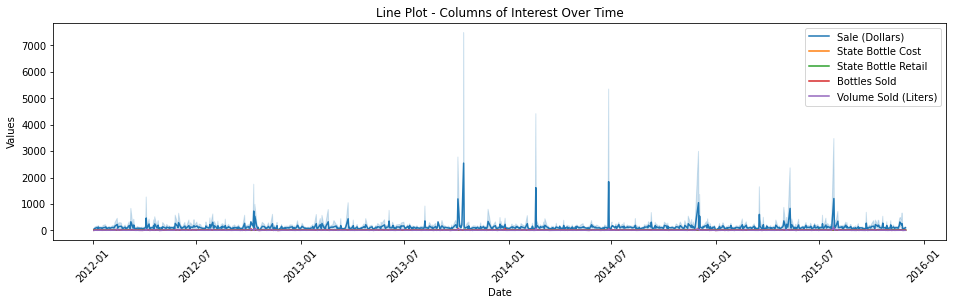

In [11]:
columns_of_interest = ['Date', 'Sale (Dollars)', 'State Bottle Cost', 
                       'State Bottle Retail', 'Bottles Sold',  'Volume Sold (Liters)']

# select only the first 10000 rows
df_sample = df[columns_of_interest].head(10000)

# convert the 'Date' column to a pandas datetime object
df_sample['Date'] = pd.to_datetime(df_sample['Date'])

# seting the figure size
plt.figure(figsize=(16, 4))

# create a line plot for each column over time (Date)
sns.lineplot(x='Date', y='Sale (Dollars)', data=df_sample, label='Sale (Dollars)')
sns.lineplot(x='Date', y='State Bottle Cost', data=df_sample, label='State Bottle Cost')
sns.lineplot(x='Date', y='State Bottle Retail', data=df_sample, label='State Bottle Retail')
sns.lineplot(x='Date', y='Bottles Sold', data=df_sample, label='Bottles Sold')
sns.lineplot(x='Date', y='Volume Sold (Liters)', data=df_sample, label='Volume Sold (Liters)')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# set the labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Line Plot - Columns of Interest Over Time')

# show the legend
plt.legend()

# show the plot
plt.show()


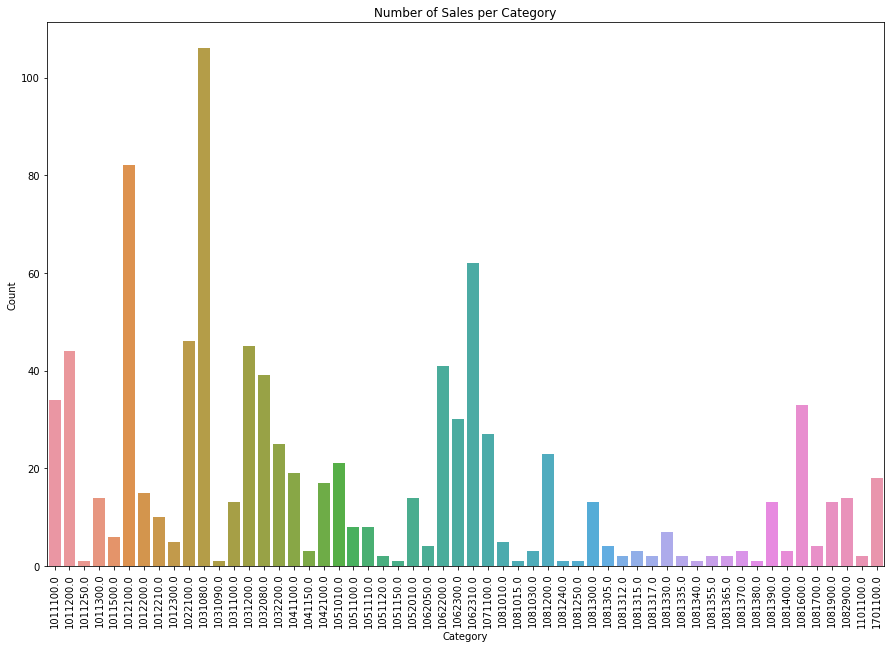

In [12]:
# sample a smaller subset for plotting (e.g., first 1000 rows)
sample_df = df.head(1000).copy() 

# plot a bar chart for the number of sales per category
plt.figure(figsize=(15, 10))
sns.countplot(x='Category', data=sample_df)
plt.xticks(rotation=90)
plt.title('Number of Sales per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

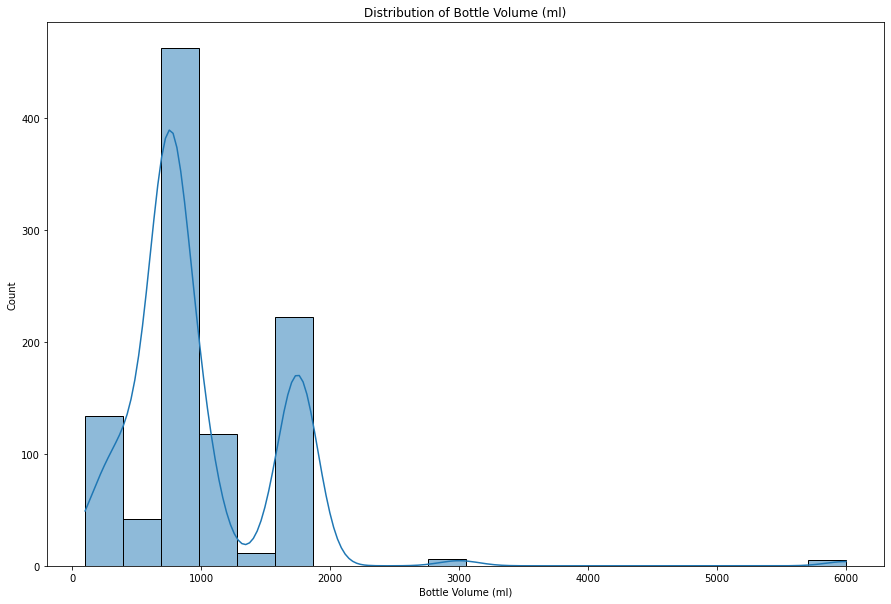

In [13]:
# plot a histogram for the bottle volume in ml
plt.figure(figsize=(15, 10))
sns.histplot(sample_df['Bottle Volume (ml)'], bins=20, kde=True)
plt.title('Distribution of Bottle Volume (ml)')
plt.xlabel('Bottle Volume (ml)')
plt.ylabel('Count')
plt.show()

### 3.	Handle the NaN values in the data set.

In [14]:
# check if the are mising values
df.isnull().sum()

Invoice/Item Number         0
Date                        0
Store Number                0
Zip Code                10360
Category                 8020
Vendor Number               3
Item Number                 0
Pack                        0
Bottle Volume (ml)          0
State Bottle Cost          10
State Bottle Retail        10
Bottles Sold                0
Sale (Dollars)             10
Volume Sold (Liters)        0
dtype: int64

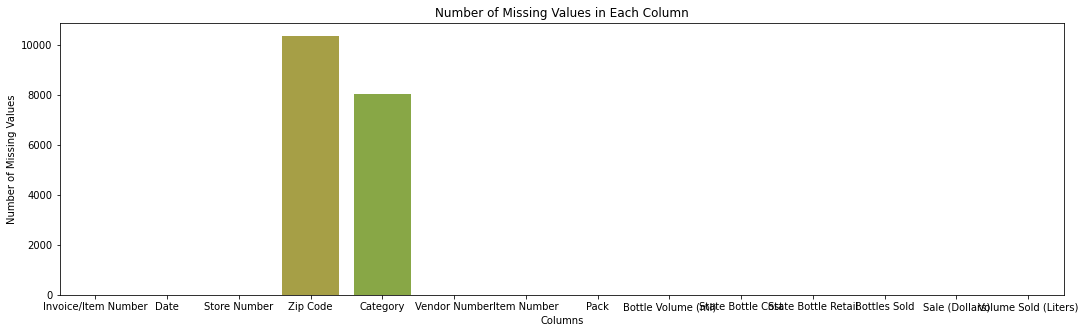

In [15]:
# calculate the number of missing values in each column
missing = df.isnull().sum()

# plot the number of missing values in each column
plt.figure(figsize=(18, 5))
sns.barplot(x=missing.index, y=missing.values)

# add labels and title to the plot
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Number of Missing Values in Each Column")

# show the plot
plt.show()

In [16]:
# columns with missing values
columns_with_nan = ['Zip Code', 'Category', 'Vendor Number', 'State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']

# create a SimpleImputer instance to fill missing values with the most frequent value for each column
imputer_most_frequent = SimpleImputer(strategy='most_frequent')

# fill the missing values in the DataFrame
df[columns_with_nan] = imputer_most_frequent.fit_transform(df[columns_with_nan])

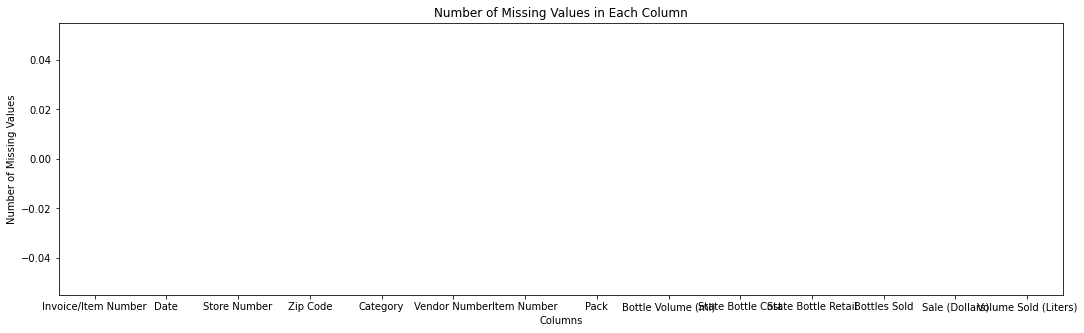

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculating the number of missing values in each column
missing = df.isnull().sum()

# plot the number of missing values in each column
plt.figure(figsize=(18,5))
sns.barplot(x=missing.index, y=missing.values)

# add labels and title to the plot
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Number of Missing Values in Each Column")

plt.show()

In [18]:
# check if the are mising values
df.isnull().sum()

Invoice/Item Number     0
Date                    0
Store Number            0
Zip Code                0
Category                0
Vendor Number           0
Item Number             0
Pack                    0
Bottle Volume (ml)      0
State Bottle Cost       0
State Bottle Retail     0
Bottles Sold            0
Sale (Dollars)          0
Volume Sold (Liters)    0
dtype: int64

### 4.	Apply some post-processing and post-analysis techniques such as Feature Selection, Feature Engineering, or others and see if they can help you.

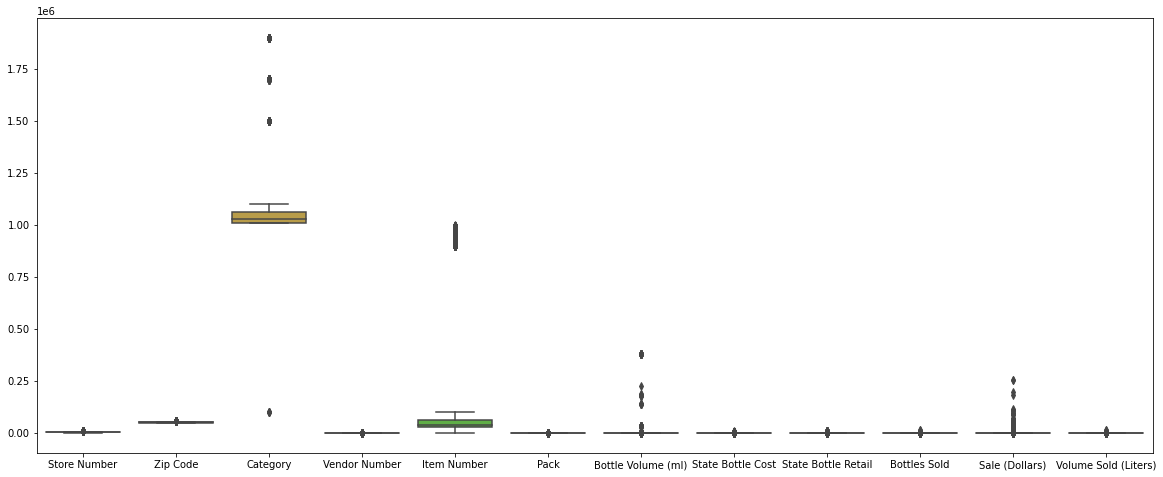

In [19]:
# checking for outliers

# Create a bigger figure
plt.figure(figsize=(20, 8))

# Create a box plot of the data
sns.boxplot(data=df)

# Identify the outliers
q1 = df.quantile(0.25, numeric_only=True)
q3 = df.quantile(0.75, numeric_only=True)
iqr = q3 - q1

outliers = ((df.select_dtypes(include='number') < (q1 - 1.5 * iqr)) | (df.select_dtypes(include='number') > (q3 + 1.5 * iqr))).any(axis=1)

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Identify the outliers
q1 = df.quantile(0.25, numeric_only=True)
q3 = df.quantile(0.75, numeric_only=True)
iqr = q3 - q1

outliers = ((df.select_dtypes(include='number') < (q1 - 1.5 * iqr)) | (df.select_dtypes(include='number') > (q3 + 1.5 * iqr))).any(axis=1)

# Remove the outliers from the new DataFrame
df = df[~outliers]

# Print the DataFrame without outliers
df.head(10)

,Invoice/Item Number,Date,Store Number,Zip Code,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
0,S29198800001,11/20/2015,2191,52632.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
17,S29196300002,11/24/2015,2595,51442.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
20,S29198700002,11/24/2015,5093,52753.0,1031080.0,255.0,297,6,750,18.09,27.14,3,81.42,2.25
32,S29198100002,11/23/2015,4162,52404.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
45,S29197300002,11/21/2015,3443,51503.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
47,S29197500002,11/20/2015,3525,52353.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
51,S29199400001,11/21/2015,2544,50158.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
54,S29198200002,11/21/2015,4311,50501.0,1031080.0,255.0,297,6,750,18.09,27.14,2,54.28,1.50
60,S29198000002,11/21/2015,3942,52342.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50
65,S29199500001,11/20/2015,2555,52632.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50


In [21]:
df.count()

Invoice/Item Number     7469420
Date                    7469420
Store Number            7469420
Zip Code                7469420
Category                7469420
Vendor Number           7469420
Item Number             7469420
Pack                    7469420
Bottle Volume (ml)      7469420
State Bottle Cost       7469420
State Bottle Retail     7469420
Bottles Sold            7469420
Sale (Dollars)          7469420
Volume Sold (Liters)    7469420
dtype: int64

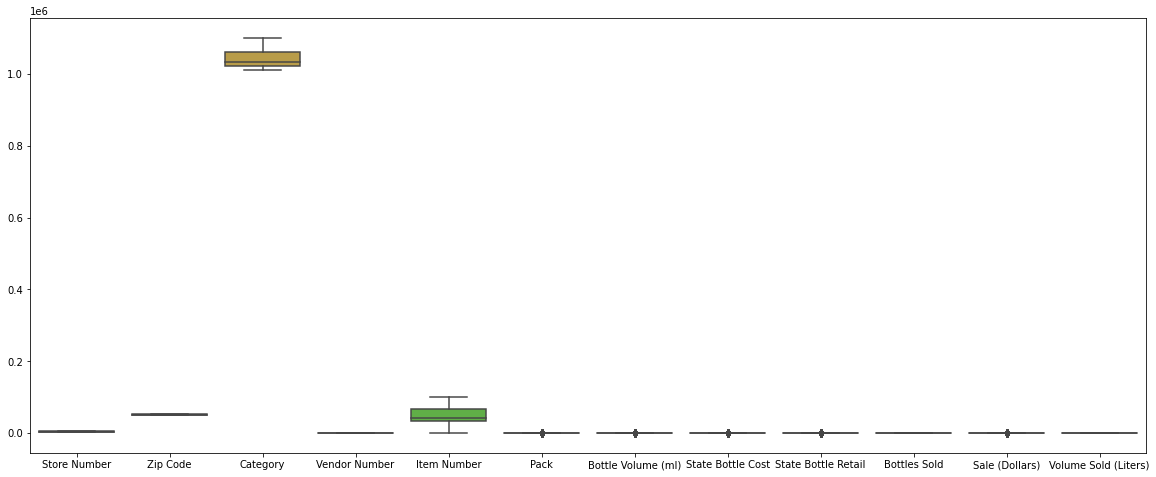

In [22]:
# checking for outliers

# Create a bigger figure
plt.figure(figsize=(20, 8))

# Create a box plot of the data
sns.boxplot(data=df)

# Identify the outliers
q1 = df.quantile(0.25, numeric_only=True)
q3 = df.quantile(0.75, numeric_only=True)
iqr = q3 - q1

outliers = ((df.select_dtypes(include='number') < (q1 - 1.5 * iqr)) | (df.select_dtypes(include='number') > (q3 + 1.5 * iqr))).any(axis=1)

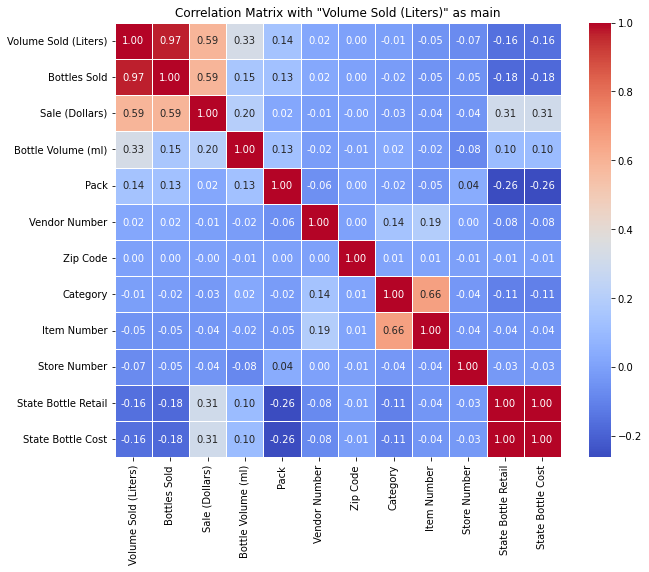

In [23]:
columns_of_interest = ['Store Number', 'Zip Code', 'Category', 'Vendor Number', 'Item Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)']
numeric_columns = df[columns_of_interest].select_dtypes(include='number')

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# sort the correlation matrix based on 'Volume Sold (Liters)' column
target_column = 'Volume Sold (Liters)'
corr_matrix = corr_matrix.sort_values(by=target_column, axis=0, ascending=False)
corr_matrix = corr_matrix.sort_values(by=target_column, axis=1, ascending=False)

# Create a figure and axes
plt.figure(figsize=(10, 8))

# Plot the correlation heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix with "Volume Sold (Liters)" as main')
plt.show()


### some conclusion
for now there are some columns with the corelation but I tkink that this column is not enough that why I decide to create two new columns that will have for creting the model

In [24]:
columns_of_interest = ['Store Number', 'Category', 'Vendor Number', 'Item Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)']
numeric_columns = df[columns_of_interest].select_dtypes(include='number')

# Log Transformation of 'Bottles Sold' and 'Sale (Dollars)'
df['Bottles Sold Log'] = np.log1p(df['Bottles Sold'])
df['Sale (Dollars) Log'] = np.log1p(df['Sale (Dollars)'])

# Polynomial Features for 'Bottles Sold' and 'Volume Sold (Liters)'
df['Bottles Sold Squared'] = df['Bottles Sold'] ** 2
df['Volume Sold (Liters) Squared'] = df['Volume Sold (Liters)'] ** 2

df.head()

,Invoice/Item Number,Date,Store Number,Zip Code,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Bottles Sold Log,Sale (Dollars) Log,Bottles Sold Squared,Volume Sold (Liters) Squared
0,S29198800001,11/20/2015,2191,52632.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
17,S29196300002,11/24/2015,2595,51442.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
20,S29198700002,11/24/2015,5093,52753.0,1031080.0,255.0,297,6,750,18.09,27.14,3,81.42,2.25,1.386294,4.411828,9,5.0625
32,S29198100002,11/23/2015,4162,52404.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
45,S29197300002,11/21/2015,3443,51503.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500


In [25]:
free_df = df.copy()

P-value-based feature selection

C:\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Feature p-values:
Store Number: NaN or division by zero
Zip Code: NaN or division by zero
Category: NaN or division by zero
Vendor Number: NaN or division by zero
Item Number: NaN or division by zero
Pack: NaN or division by zero
Bottle Volume (ml): NaN or division by zero
State Bottle Cost: NaN or division by zero
State Bottle Retail: NaN or division by zero
Bottles Sold: NaN or division by zero
Sale (Dollars): NaN or division by zero
Volume Sold (Liters): NaN or division by zero
Bottles Sold Log: NaN or division by zero
Sale (Dollars) Log: NaN or division by zero
Bottles Sold Squared: NaN or division by zero


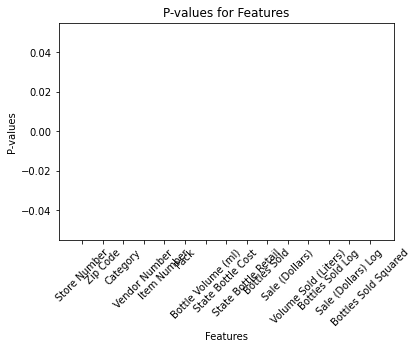

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

columns_of_interest = ['Store Number', 'Zip Code', 'Category', 'Vendor Number', 'Item Number', 'Pack',
                       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
                       'Sale (Dollars)', 'Volume Sold (Liters)', 'Bottles Sold Log', 'Sale (Dollars) Log',
                       'Bottles Sold Squared', 'Volume Sold (Liters) Squared']

# Separate features and target based on the columns_of_interest
X = free_df[columns_of_interest].drop('Volume Sold (Liters)', axis=1)
y = free_df['Volume Sold (Liters)']

# Create the SelectKBest instance with f_classif scoring function and k='all' to get all p-values
selector = SelectKBest(score_func=f_classif, k='all')

# Fit the selector to the data
selector.fit(X, y)

# Get p-values
p_values = selector.pvalues_

# Combine column names and p-values
column_p_values = list(zip(columns_of_interest[:-1], p_values))  # Exclude the target column from the output

# Suppress runtime warnings during printing
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    # Print p-values for each feature
    print("Feature p-values:")
    for column, p_value in column_p_values:
        if np.isnan(p_value) or p_value == 0:
            print(f"{column}: NaN or division by zero")
        else:
            print(f"{column}: {p_value}")

# Plot the p-values
plt.bar([col for col, _ in column_p_values], [p for _, p in column_p_values])
plt.xlabel('Features')
plt.ylabel('P-values')
plt.title('P-values for Features')
plt.xticks(rotation=45)
plt.show()


analyzing the plot I don't see any dotted lines, that's mean that selector doesn't eliminate any features

In [27]:
# import the library
from kydavra import PearsonCorrelationSelector

# call the method
pearson = PearsonCorrelationSelector()

# implement the method
selected_columns = pearson.select(free_df, 'Volume Sold (Liters)') 

print(selected_columns) 

C:\Python310\lib\site-packages\kydavra\PearsonCorrelationSelector.py:65: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.corr_table = dataframe.corr()


['State Bottle Cost', 'Bottles Sold', 'Sale (Dollars)', 'Sale (Dollars) Log', 'Bottles Sold Squared']


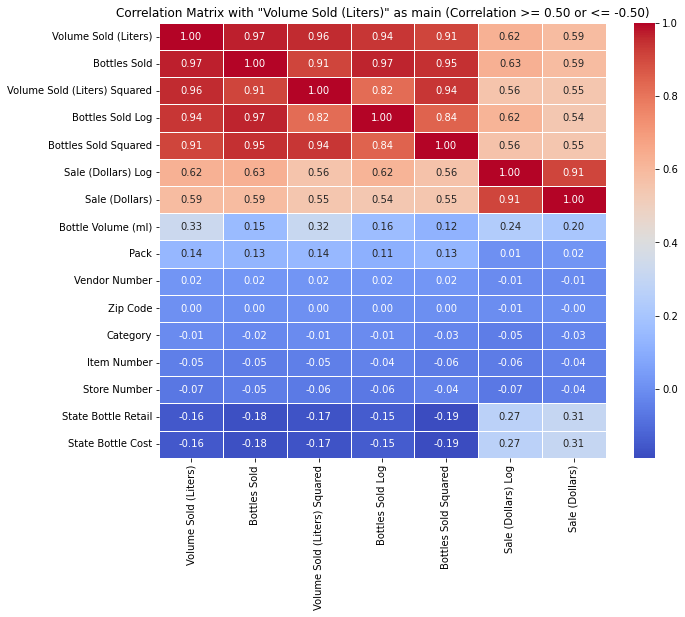

In [28]:
columns_of_interest = ['Store Number', 'Zip Code', 'Category', 'Vendor Number', 'Item Number', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Bottles Sold Log', 'Sale (Dollars) Log', 'Bottles Sold Squared', 'Volume Sold (Liters) Squared']
numeric_columns = df[columns_of_interest].select_dtypes(include='number')

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# sorting the correlation matrix based on 'Volume Sold (Liters)' column
target_column = 'Volume Sold (Liters)'
corr_matrix = corr_matrix.sort_values(by=target_column, axis=0, ascending=False)
corr_matrix = corr_matrix.sort_values(by=target_column, axis=1, ascending=False)

# filter the columns with correlation greater than or equal to 0.10 or less than or equal to -0.10
high_correlation_columns = corr_matrix.columns[(corr_matrix[target_column] >= 0.50) | (corr_matrix[target_column] <= -0.50)]

# create a figure and axes
plt.figure(figsize=(10, 8))

# plot the correlation heatmap for the selected columns
sns.heatmap(corr_matrix[high_correlation_columns],
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5)

# show the plot
plt.title('Correlation Matrix with "Volume Sold (Liters)" as main (Correlation >= 0.50 or <= -0.50)')
plt.show()


### 5.	Create a model or a Pipeline that will show the best performance in predicting the target column.

the column that will be used for create our model is:
- 'Bottles Sold',
- 'Volume Sold (Liters) Squared',
- 'Bottles Sold Log',
- 'Bottles Sold Squared', 
- 'Sale (Dollars) Log',
- 'Sale (Dollars)', 


In [75]:
df.head(10)

,Invoice/Item Number,Date,Store Number,Zip Code,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Bottles Sold Log,Sale (Dollars) Log,Bottles Sold Squared,Volume Sold (Liters) Squared
0,S29198800001,11/20/2015,2191,52632.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
17,S29196300002,11/24/2015,2595,51442.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
20,S29198700002,11/24/2015,5093,52753.0,1031080.0,255.0,297,6,750,18.09,27.14,3,81.42,2.25,1.386294,4.411828,9,5.0625
32,S29198100002,11/23/2015,4162,52404.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
45,S29197300002,11/21/2015,3443,51503.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
47,S29197500002,11/20/2015,3525,52353.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
51,S29199400001,11/21/2015,2544,50158.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
54,S29198200002,11/21/2015,4311,50501.0,1031080.0,255.0,297,6,750,18.09,27.14,2,54.28,1.50,1.098612,4.012411,4,2.2500
60,S29198000002,11/21/2015,3942,52342.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500
65,S29199500001,11/20/2015,2555,52632.0,1031080.0,255.0,297,6,750,18.09,27.14,6,162.84,4.50,1.945910,5.098890,36,20.2500


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Evaluate the model using MSE, MAE, and R-squared
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    
    return mse, mae, r_squared

# Assuming you already have 'df' loaded with the final dataset
feature_columns = ['Bottles Sold', 'Volume Sold (Liters) Squared', 'Bottles Sold Log', 'Bottles Sold Squared', 'Sale (Dollars) Log', 'Sale (Dollars)']
target_column = 'Volume Sold (Liters)'

# Separate features and target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a dictionary to store model names and their corresponding pipelines
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression())
    ]),
    'Decision Tree Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ])
}

# Train and evaluate each model in the dictionary
for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    mse, mae, r_squared = evaluate_model(model_pipeline, X_test, y_test)
    
    print(f"\n{model_name}")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared:", r_squared)



Linear Regression
Mean Squared Error (MSE): 0.0054378928722793795
Mean Absolute Error (MAE): 0.043052797263215
R-squared: 0.9996600921844522

Decision Tree Regression
Mean Squared Error (MSE): 2.5374571698110045e-07
Mean Absolute Error (MAE): 1.1959875553366015e-06
R-squared: 0.999999984139049

Random Forest Regression
Mean Squared Error (MSE): 1.450006649333793e-07
Mean Absolute Error (MAE): 1.181082335063048e-06
R-squared: 0.9999999909364049


In [34]:
feature_columns = ['Bottles Sold', 'Volume Sold (Liters) Squared', 'Bottles Sold Log', 'Bottles Sold Squared', 'Sale (Dollars) Log', 'Sale (Dollars)']
target_column = 'Volume Sold (Liters)'

# Separate features and target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a dictionary with the models and pipelines we want to evaluate
models = {
    'Ridge Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('regressor', Ridge(alpha=1.0))
    ]),
    # Add more models here if desired
}

# Train and evaluate each model in the dictionary

print(f"\n{model_name}")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r_squared)



Ridge Regression
Mean Squared Error (MSE): 0.005448032518268875
Mean Absolute Error (MAE): 0.043267342452092614
R-squared: 0.9996594583829045


### it's seem that the models is overfitting
- try to change smth

 cross-validation, learning curves, regularization, feature selection, and validation curves. 

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # evaluate the model using MSE, MAE, and R-squared
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    
    return mse, mae, r_squared

feature_columns = ['Bottles Sold', 'Volume Sold (Liters) Squared', 'Bottles Sold Log', 'Bottles Sold Squared', 'Sale (Dollars) Log', 'Sale (Dollars)']
target_column = 'Volume Sold (Liters)'

# Separate features and target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the models
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression())
    ]),
    'Decision Tree Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ])
}

# train and evaluate each model in the dictionary
for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    mse, mae, r_squared = evaluate_model(model_pipeline, X_test, y_test)
    
    print(f"\n{model_name} Evaluation:")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared:", r_squared)

    # Cross-validation
    cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse_scores = -cv_scores
    print("\nCross-Validation MSE Scores:", cv_mse_scores)
    print("Mean Cross-Validation MSE:", np.mean(cv_mse_scores))

    # Learning curves
    train_sizes, train_scores, val_scores = learning_curve(model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    train_mse = -np.mean(train_scores, axis=1)
    val_mse = -np.mean(val_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mse, label='Training MSE')
    plt.plot(train_sizes, val_mse, label='Validation MSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'{model_name} Learning Curves')
    plt.legend()

    # Training vs. Test performance
    train_mse, test_mse = [], []
    for _ in range(10):
        X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.8, random_state=np.random.randint(1, 100))
        model_pipeline.fit(X_train_sub, y_train_sub)
        train_mse.append(mean_squared_error(y_train_sub, model_pipeline.predict(X_train_sub)))
        test_mse.append(mean_squared_error(y_test, model_pipeline.predict(X_test)))

    plt.figure()
    plt.plot(range(10), train_mse, label='Training MSE')
    plt.plot(range(10), test_mse, label='Test MSE')
    plt.xlabel('Random Subset')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'{model_name} Training vs. Test Performance')
    plt.legend()

    # Regularization (L2 - Ridge)
    if 'regressor__alpha' in model_pipeline.get_params():
        alphas = [0.01, 0.1, 1.0, 10.0]
        train_scores, val_scores = validation_curve(model_pipeline, X, y, param_name='regressor__alpha', param_range=alphas, cv=5, scoring='neg_mean_squared_error')
        train_mse = -np.mean(train_scores, axis=1)
        val_mse = -np.mean(val_scores, axis=1)

        plt.figure()
        plt.plot(alphas, train_mse, label='Training MSE')
        plt.plot(alphas, val_mse, label='Validation MSE')
        plt.xscale('log')
        plt.xlabel('Alpha (Regularization Strength)')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title(f'{model_name} Validation Curves (Regularization)')
        plt.legend()

    # Feature selection (SelectKBest)
    if 'polynomial_features__degree' in model_pipeline.get_params():
        selector = SelectKBest(score_func=f_regression, k=4)
        X_selected = selector.fit_transform(X, y)

        selected_feature_indices = selector.get_support(indices=True)
        selected_feature_names = [feature_columns[i] for i in selected_feature_indices]
        print("\nSelected Features:", selected_feature_names)

plt.show()



Linear Regression Evaluation:
Mean Squared Error (MSE): 0.0054378928722793795
Mean Absolute Error (MAE): 0.043052797263215
R-squared: 0.9996600921844522

Cross-Validation MSE Scores: [0.00501284 0.00509202 0.00506808 0.00533313 0.01272284]
Mean Cross-Validation MSE: 0.00664578208965369

Selected Features: ['Bottles Sold', 'Volume Sold (Liters) Squared', 'Bottles Sold Log', 'Bottles Sold Squared']

Decision Tree Regression Evaluation:
Mean Squared Error (MSE): 2.838239113612427e-07
Mean Absolute Error (MAE): 1.4994470832088756e-06
R-squared: 0.9999999822589433

Cross-Validation MSE Scores: [6.69396017e-11 6.69396017e-11 6.35256820e-08 1.60454225e-07
 1.85288818e-06]
Mean Cross-Validation MSE: 4.154003925338023e-07

Random Forest Regression Evaluation:
Mean Squared Error (MSE): 1.5136543845885647e-07
Mean Absolute Error (MAE): 1.1690778331403094e-06
R-squared: 0.9999999905385603

Cross-Validation MSE Scores: [1.53017236e-10 1.50827976e-08 4.21045208e-08 1.19835804e-07
 1.38569402e-06]
M